In [48]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.STNSRP.Simulation import Simulation
from NEOPRENE.STNSRP.Analysis import Analysis
from NEOPRENE.STNSRP.utils import allmonths
import pandas as pd
import os
import GPy
from sklearn.preprocessing import StandardScaler
import tqdm
import sys
import math as mt
import matplotlib.pyplot as plt
from math import *

In [49]:
import numpy as np

def generate_grid(lat_min, lat_max, lon_min, lon_max, cell_size):
    lat_steps = int((lat_max - lat_min) / (cell_size / 111.32))
    lon_steps = int((lon_max - lon_min) / (cell_size / (111.32 * np.cos(np.radians(lat_min)))))
    
    lat_grid = np.linspace(lat_min, lat_max, lat_steps)
    lon_grid = np.linspace(lon_min, lon_max, lon_steps)
    
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)
    return lat_grid, lon_grid


In [50]:
def get_month_parameters(monthly_params, month_idx):
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    month_col = month_map[month_idx]
    landa = monthly_params.loc['landa', month_col]
    mu_c = monthly_params.loc['ipsilon', month_col]
    eta = monthly_params.loc['eta', month_col]
    betha = monthly_params.loc['betha', month_col]
    alpha = 1.0  # Suponiendo alpha = 1 para simplificación, ajustar según sea necesario
    alpha_p = 1.0  # Suponiendo alpha_p = 1 para simplificación, ajustar según sea necesario
    xi = 1.0  # Suponiendo xi = 1 para simplificación, ajustar según sea necesario
    return landa, mu_c, eta, betha, alpha, alpha_p, xi

In [53]:
# Definir la función de distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radio de la Tierra en metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Generación de campos de precipitación

In [54]:
Attributes_SPD= pd.read_csv('./auxiliary-materials/SPD/Attributes.csv',index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.index
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values

In [55]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SPD.yml')

In [56]:
daily_series = pd.read_csv('./POINT_SPATIAL_DAILY/SIM1/Time_serie_daily_simulated.csv',index_col=0, parse_dates=True)

In [57]:
daily_series = daily_series.loc['2005':'2025']

In [58]:
# Parámetros de la rejilla
lat_min = 43.125
lat_max = 43.425
lon_min = -3.725
lon_max = -3.25
cell_size = 0.5  # Tamaño de la celda en km

# Generar la rejilla
lat_grid, lon_grid = generate_grid(lat_min, lat_max, lon_min, lon_max, cell_size)

In [59]:
calibrated_params = pd.read_csv('./POINT_SPATIAL_DAILY/CAL1/Calibrated_parameters.csv',index_col=0)

In [60]:
calibrated_params

,"(1, 2, 3)","(4, 5, 6)","(7, 8, 9)","(10, 11, 12)"
landa,0.178261,0.191083,0.142086,0.140195
ipsilon,8.048909,5.917655,5.696891,9.760525
eta,1600.000000,1600.000000,1600.000000,1600.000000
betha,0.852858,1.099017,0.995313,0.797710
fi_may,0.050000,0.050000,0.050000,0.050000


In [61]:
X = Input_Attr[['X', 'Y']].values

In [15]:
# Escalar los datos
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

In [16]:
calibrated_params_month = allmonths(calibrated_params.T)

In [17]:
lon_lat_vector = np.column_stack((lon_grid.ravel(),lat_grid.ravel()))

In [18]:
results = np.zeros((len(daily_series),lat_grid.shape[0],lat_grid.shape[1]))

In [19]:
X_new_scaled_realistic = scaler_X.transform(lon_lat_vector)

In [63]:
# Crear un diccionario para almacenar las predicciones
predicciones = {}

# Escalar las nuevas coordenadas
X_new_scaled_realistic = scaler_X.transform(lon_lat_vector)

# Iterar sobre cada registro de la serie temporal
t=0
for index, row in tqdm.tqdm(daily_series.iloc[22:].iterrows()):
    # Obtener el mes del registro actual
    mes = index.month
    
    # Obtener los parámetros para el mes actual
    landa, mu_c, eta, betha, alpha = calibrated_params_month.loc[mes,:]
    
    
    # Extraer los datos de precipitación para el registro actual
    Y = row.values.reshape(-1, 1)
    t = t+1
    if np.max(Y)>0:
        sys.exit()

0it [00:00, ?it/s]


SystemExit: 

 c:\Anaconda3\envs\NEOPRENE_2024\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning:To exit: use 'exit', 'quit', or Ctrl-D.


# Interpolación Espacial de Precipitación usando Gaussian Processes

Este documento explica el proceso de interpolación espacial de la precipitación utilizando Gaussian Processes, basado en la matriz de covarianza definida por Cowperwait (1991). Se utilizan `numba` y `joblib` para mejorar la eficiencia computacional.

## Conceptos Básicos

### Gaussian Processes (GP)
Los Gaussian Processes son modelos no paramétricos utilizados para la regresión y la interpolación de datos. Un GP define una distribución sobre funciones y se utiliza para predecir valores en puntos no observados utilizando una función de covarianza que describe la relación entre los puntos observados y no observados.

### Matriz de Covarianza de Cowperwait (1991)
La matriz de covarianza en Gaussian Processes define cómo los valores en diferentes ubicaciones se correlacionan entre sí. La implementación de Cowperwait (1991) utiliza un modelo de proceso puntual agrupado de Neyman-Scott para modelar la precipitación. La covarianza se calcula usando una fórmula específica que incorpora varios parámetros.

## Formulaciones Matemáticas

### Función `E_X`
La función \(E_X\) calcula el valor esperado de \(X^p\):

$$
E_X(\xi, \alpha, p) = \xi^p \cdot \alpha^p
$$

### Función de Covarianza `NSRP_covariance`
La función de covarianza basada en el modelo de Cowperwait (1991) se define como:

$$
\text{NSRP\_covariance}(h, l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p) = \sum_{i=1}^{n} \left( \text{term1} - \text{term2} \right) 
$$

Para \( l = 0 \):

$$
A = \eta \cdot h - 1 + \exp(-\eta \cdot h)
$$

$$
B = \beta \cdot h - 1 + \exp(-\beta \cdot h)
$$

Para \( l > 0 \):

$$
A = 0.5 \left( (1 - \exp(-\eta \cdot h))^2 \right) \cdot \exp(-\eta \cdot h \cdot (l - 1))
$$

$$
B = 0.5 \left( (1 - \exp(-\beta \cdot h))^2 \right) \cdot \exp(-\beta \cdot h \cdot (l - 1))
$$

Términos:

$$
\text{term1} = \alpha_p \cdot \left( \lambda \cdot \eta^{-3} \cdot A \cdot \left( 2 \cdot \mu_c \cdot E_X\left( \frac{1}{\xi}, \alpha, 2 \right) + \left( E_X\left( \frac{1}{\xi}, \alpha, 1 \right)^2 \right) \cdot \beta^2 \cdot \frac{\mu_c^2}{\beta^2 - \eta^2} \right) \right)
$$

$$
\text{term2} = \lambda \cdot \left( E_X\left( \frac{1}{\xi}, \alpha, 1 \right)^2 \right) \cdot B \cdot \frac{\mu_c^2}{\beta \cdot (\beta^2 - \eta^2)}
$$

$$
\text{NSRP\_covariance}(h, l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p) = \sum_{i=1}^{n} \left( \alpha_{p,i} \cdot \left( \lambda_i \cdot \eta_i^{-3} \cdot A \cdot \left( 2 \cdot \mu_{c,i} \cdot E_X\left( \frac{1}{\xi_i}, \alpha_i, 2 \right) + \left( E_X\left( \frac{1}{\xi_i}, \alpha_i, 1 \right)^2 \right) \cdot \beta_i^2 \cdot \frac{\mu_{c,i}^2}{\beta_i^2 - \eta_i^2} \right) \right) - \lambda_i \cdot \left( E_X\left( \frac{1}{\xi_i}, \alpha_i, 1 \right)^2 \right) \cdot B \cdot \frac{\mu_{c,i}^2}{\beta_i \cdot (\beta_i^2 - \eta_i^2)} \right) 
$$


### Función de Distancia `haversine`
La fórmula de la distancia Haversine calcula la distancia entre dos puntos en la superficie de una esfera, dadas sus latitudes y longitudes:

$$
a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
$$

$$
c = 2 \cdot \arctan2(\sqrt{a}, \sqrt{1 - a})
$$

$$
d = R \cdot c
$$

donde:
- $\phi$ es la latitud,
- $\lambda$ es la longitud,
- $R$ es el radio de la Tierra (aproximadamente 6371 km).

### Creación de la Matriz de Covarianza
Para crear la matriz de covarianza para un conjunto de puntos, se utiliza la función de covarianza de Cowperwait y la distancia haversine para calcular la covarianza entre cada par de puntos.

Para los puntos observados:

$$
\text{cov\_matrix}[i, j] = \text{NSRP\_covariance}(\text{haversine}(\text{points}[i], \text{points}[j]), l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p)
$$

Para los puntos de predicción:

$$
K_{\text{star}}[i, j] = \text{NSRP\_covariance}(\text{haversine}(\text{pred\_points}[i], \text{points}[j]), l, \lambda, \mu_c, \eta, \xi, \beta, \alpha, \alpha_p)
$$

### Proceso de Interpolación
1. **Datos de Entrada**: Coordenadas de los puntos de observación ($X$) y valores observados ($Y$).
2. **Parámetros de Covarianza**: Los parámetros del modelo de covarianza ($\lambda, \mu_c, \eta, \beta, \alpha, \alpha_p, \xi$) son calibrados y proporcionados.
3. **Cálculo de la Matriz de Covarianza**: Se genera la matriz de covarianza ($K$) para los puntos observados y la matriz de covarianza cruzada ($K_{\text{star}}$) para los puntos de predicción.
4. **Predicción**: Se realiza la predicción de los valores de precipitación en los puntos de predicción utilizando las matrices de covarianza calculadas:

$$
\bar{f_*} = K_{\text{star}} K^{-1} \mathbf{y}
$$

5. **Cálculo de Incertidumbre**: Se calcula la incertidumbre de las predicciones:

$$
\text{Cov}(\mathbf{f}_*) = K_{\text{**}} - K_{\text{star}} K^{-1} K_{\text{star}}^T
$$

### Predicción

La expresión $\text{y\_pred} = K_{\text{star}} K^{-1} \text{values}$ se utiliza para calcular la media de las predicciones en los puntos de predicción. Aquí:

- $K(\mathbf{X}_*, \mathbf{X})$ es $K_{\text{star}}$, la matriz de covarianza entre los puntos de predicción y los puntos de entrenamiento.
- $K(\mathbf{X}, \mathbf{X})$ es $K$, la matriz de covarianza entre los puntos de entrenamiento.
- $\mathbf{y}$ son los valores observados en los puntos de entrenamiento.

Esto se deriva de la fórmula para la media condicional en Gaussian Processes:

$$
\bar{\mathbf{f}}_* = K(\mathbf{X}_*, \mathbf{X}) K(\mathbf{X}, \mathbf{X})^{-1} \mathbf{y}
$$

Esta fórmula es fundamental para obtener las predicciones de los valores de precipitación en los puntos de predicción.

### Fuentes Bibliográficas
La metodología de covarianza y los cálculos están basados en:

- Cowperwait, P. (1991). "Further Developments of the Neyman-Scott Clustered Point Process for Modeling Rainfall." Water Resources Research, 27(7), 1431-1438.

La optimización computacional y el uso de `numba` y `joblib` se basan en las mejores prácticas recomendadas en:

- Lam, S. K., Pitrou, A., & Seibert, S. (2015). "Numba: A LLVM-based Python JIT compiler." Proceedings of the Second Workshop on the LLVM Compiler Infrastructure in HPC. ACM, 2015.
- Joblib Development Team. "Joblib: running Python functions as pipeline jobs." (2020).

Las formulaciones matemáticas y la teoría detrás de Gaussian Processes están basadas en:

- Rasmussen, C. E., & Williams, C. K. I. (2006). "Gaussian Processes for Machine Learning." MIT Press. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)





In [232]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
from scipy.spatial.distance import cdist
import math as mt
from joblib import Parallel, delayed

class NSRPKernel(Kernel):
    def __init__(self, landa, mu_c, eta, xi, betha, alpha, alpha_p, n_jobs=-1):
        self.landa = np.asarray(landa)
        self.mu_c = np.asarray(mu_c)
        self.eta = np.asarray(eta)
        self.xi = np.asarray(xi)
        self.betha = np.asarray(betha)
        self.alpha = np.asarray(alpha)
        self.alpha_p = np.asarray(alpha_p)
        self.n_jobs = n_jobs

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X
        
        dists = cdist(X, Y, metric=lambda u, v: haversine(u[0], u[1], v[0], v[1]))
        if eval_gradient:
            raise NotImplementedError("Gradient is not implemented")
        return self.NSRP_covariance_matrix(dists)
    
    def NSRP_covariance_matrix(self, dists):
        result = np.zeros(dists.shape)
        
        def compute_term(i):
            A = self.eta[i] * dists - 1 + np.exp(-self.eta[i] * dists)
            B = self.betha[i] * dists - 1 + np.exp(-self.betha[i] * dists)
            
            term1 = self.alpha_p[i] * (self.landa[i] * (self.eta[i] ** -3) * A *
                                  (2 * self.mu_c[i] * E_X(1 / self.xi[i], self.alpha[i], 2) +
                                   (E_X(1 / self.xi[i], self.alpha[i], 1) ** 2) * (self.betha[i] ** 2) *
                                   (self.mu_c[i] ** 2) / ((self.betha[i] ** 2) - (self.eta[i] ** 2))))
            
            term2 = self.landa[i] * (E_X(1 / self.xi[i], self.alpha[i], 1) ** 2) * B * \
                    (self.mu_c[i] ** 2) / (self.betha[i] * ((self.betha[i] ** 2) - (self.eta[i] ** 2)))
            
            return term1 - term2
        
        results = Parallel(n_jobs=self.n_jobs)(delayed(compute_term)(i) for i in range(len(self.landa)))
        result = np.sum(results, axis=0)

        return result
    
    def diag(self, X):
        return np.zeros(X.shape[0])

    def is_stationary(self):
        return False

def E_X(xi, alpha, r):
    return (xi**r) * mt.gamma(1 + r / alpha)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, lambda1 = np.radians(lat1), np.radians(lon1)
    phi2, lambda2 = np.radians(lat2), np.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

class CustomGaussianProcessRegressor(GaussianProcessRegressor):
    def fit(self, X, y):
        self.X_train_ = X
        self.y_train_ = y
        self.kernel_ = self.kernel if self.kernel is not None else RBF()
        
        # Generar la matriz de covarianza
        K = self.kernel_(self.X_train_)
        
        # Añadir un valor pequeño a la diagonal temporalmente para la inversión
        K += np.eye(K.shape[0]) * 1e-10
        self.K_inv_ = np.linalg.inv(K)
        
        return self

    def predict(self, X, return_std=False):
        # Paralelizar el cálculo de K_trans
        def compute_k_trans_row(x):
            return self.kernel_(x.reshape(1, -1), self.X_train_).ravel()
        
        K_trans = np.array(Parallel(n_jobs=self.kernel_.n_jobs)(delayed(compute_k_trans_row)(x) for x in X))
        y_mean = K_trans.dot(self.K_inv_).dot(self.y_train_)
        
        if return_std:
            # Paralelizar el cálculo de K_star
            def compute_k_star_row(x):
                return self.kernel_(x.reshape(1, -1), X).ravel()
            
            K_star = np.array(Parallel(n_jobs=self.kernel_.n_jobs)(delayed(compute_k_star_row)(x) for x in X))
            y_var = np.diag(K_star - K_trans.dot(self.K_inv_).dot(K_trans.T))
            return y_mean, np.sqrt(np.maximum(y_var, 0))
        else:
            return y_mean

In [241]:
calibrated_params_month

,landa,ipsilon,eta,betha,fi_may
Index,,,,,
1,0.178261,8.048903,1600.0,0.852858,0.05
2,0.178261,8.048903,1600.0,0.852858,0.05
3,0.178261,8.048903,1600.0,0.852858,0.05
4,0.191083,5.917654,1600.0,1.099017,0.05
5,0.191083,5.917654,1600.0,1.099017,0.05
6,0.191083,5.917654,1600.0,1.099017,0.05
7,0.142086,5.696889,1600.0,0.995312,0.05
8,0.142086,5.696889,1600.0,0.995312,0.05
9,0.142086,5.696889,1600.0,0.995312,0.05


In [243]:
points = X
values = Y

landa, mu_c, eta, betha, fi_may = calibrated_params_month.loc[mes, :]
alpha = 1
alpha_p = 1
xi = 1

In [234]:
n = X.shape[0]
dists = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dists[i, j] = haversine(X[i, 1], X[i, 0], X[j, 1], X[j, 0])

dists = dists/1000

In [235]:
kernel = NSRPKernel([landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p],n_jobs=-1)
gp = CustomGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

In [236]:
# Ajustar el modelo a los datos
gp.fit(points, values)

CustomGaussianProcessRegressor(kernel=NSRPKernel(), n_restarts_optimizer=10,
                               normalize_y=True)

In [237]:
y_pred, sigma_pred = gp.predict(lon_lat_vector, return_std=True)

In [227]:
y_pred

array([[15.29476299],
       [15.1458742 ],
       [14.9931559 ],
       ...,
       [ 5.40284127],
       [ 5.37298199],
       [ 5.34418422]])

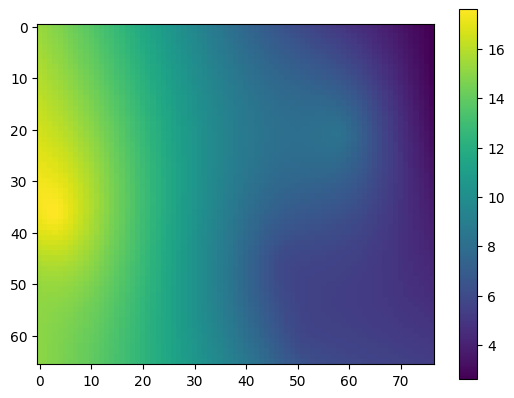

In [226]:
plt.imshow(y_pred.reshape(lat_grid.shape))
plt.colorbar()

In [228]:
import numpy as np
from numba import jit, prange
from joblib import Parallel, delayed
import math as mt

@jit(nopython=True)
def E_X(xi, alpha, r):
    return (xi**r) * mt.gamma(1 + r / alpha)

@jit(nopython=True)
def NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p):
    result = 0.0
    for i in range(len(landa)):
        if l == 0:
            A = eta[i] * h - 1 + np.exp(-eta[i] * h)
            B = betha[i] * h - 1 + np.exp(-betha[i] * h)
        elif l > 0:
            A = 0.5 * ((1 - np.exp(-eta[i] * h)) ** 2) * np.exp(-eta[i] * h * (l - 1))
            B = 0.5 * ((1 - np.exp(-betha[i] * h)) ** 2) * np.exp(-betha[i] * h * (l - 1))

        term1 = alpha_p[i] * (landa[i] * (eta[i] ** -3) * A *
                              (2 * mu_c[i] * E_X(1 / xi[i], alpha[i], 2) +
                               (E_X(1 / xi[i], alpha[i], 1) ** 2) * (betha[i] ** 2) *
                               (mu_c[i] ** 2) / ((betha[i] ** 2) - (eta[i] ** 2))))

        term2 = landa[i] * (E_X(1 / xi[i], alpha[i], 1) ** 2) * B * \
                (mu_c[i] ** 2) / (betha[i] * ((betha[i] ** 2) - (eta[i] ** 2)))

        result += term1 - term2

    return result

@jit(nopython=True)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km
    phi1, lambda1 = np.radians(lat1), np.radians(lon1)
    phi2, lambda2 = np.radians(lat2), np.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

@jit(nopython=True, parallel=True)
def create_covariance_matrix(points, landa, mu_c, eta, xi, betha, alpha, alpha_p):
    n_points = len(points)
    cov_matrix = np.zeros((n_points, n_points))

    for i in prange(n_points):
        for j in prange(n_points):
            h = haversine(points[i][0], points[i][1], points[j][0], points[j][1])
            l = 0  # Ajusta según sea necesario
            cov_matrix[i, j] = NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p)
    
    return cov_matrix

# Datos de ejemplo: coordenadas de los puntos de observación
points = X
values = Y

landa, mu_c, eta, betha, alpha = calibrated_params_month.loc[mes, :]
alpha = 1
alpha_p = 1
xi = 1

# Crear la matriz de covarianza para los puntos observados
K = create_covariance_matrix(points, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p])

# Puntos donde queremos hacer la predicción
pred_points = lon_lat_vector

def compute_k_star(i):
    K_star_row = np.zeros(len(points))
    for j in range(len(points)):
        h = haversine(pred_points[i][0], pred_points[i][1], points[j][0], points[j][1])
        l = 0  # Ajusta según sea necesario
        K_star_row[j] = NSRP_covariance(h, l, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p])
    return K_star_row

# Crear la matriz de covarianza cruzada entre puntos de predicción y puntos de observación
K_star = Parallel(n_jobs=-1)(delayed(compute_k_star)(i) for i in range(len(pred_points)))
K_star = np.array(K_star)

# Crear la matriz de covarianza para los puntos de predicción
K_star_star = create_covariance_matrix(pred_points, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p])

# Invertir la matriz K
K_inv = np.linalg.inv(K)

# Realizar la predicción
y_pred = K_star @ K_inv @ values

# Calcular la incertidumbre de las predicciones
sigma_pred = np.sqrt(np.abs(np.diag(K_star_star - K_star @ K_inv @ K_star.T)))

In [231]:
y_pred

array([[15.29476174],
       [15.14587285],
       [14.99315445],
       ...,
       [ 5.40284379],
       [ 5.37298458],
       [ 5.34418688]])

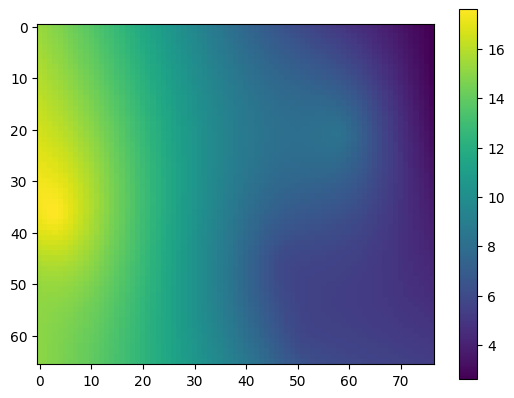

In [229]:
plt.imshow(y_pred.reshape(lat_grid.shape))
plt.colorbar()

# V 2

In [352]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
import math as mt

# Define the necessary functions
def E_X(xi, alpha, r):
    return (xi**r) * mt.gamma(1 + r / alpha)

def NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p):
    result = []
    for i in range(np.size(landa)):
        if l == 0:
            A = eta[i] * h - 1 + np.exp(-eta[i] * h)
            B = betha[i] * h - 1 + np.exp(-betha[i] * h)
        elif l > 0:
            A = 0.5 * ((1 - np.exp(-eta[i] * h)) ** 2) * np.exp(-eta[i] * h * (l - 1))
            B = 0.5 * ((1 - np.exp(-betha[i] * h)) ** 2) * np.exp(-betha[i] * h * (l - 1))
        result.append(
            alpha_p[i] * (landa[i] * (eta[i] ** -3) * A *
                          (2 * mu_c[i] * E_X(1 / xi[i], alpha[i], 2) +
                           (E_X(1 / xi[i], alpha[i], 1) ** 2) * (betha[i] ** 2) *
                           (mu_c[i] ** 2) / ((betha[i] ** 2) - (eta[i] ** 2)))) -
            landa[i] * (E_X(1 / xi[i], alpha[i], 1) ** 2) * B * (mu_c[i] ** 2) /
            (betha[i] * ((betha[i] ** 2) - (eta[i] ** 2)))
        )
    return np.sum(result)

def fy(fi_may, d, y):
    return ((fi_may * d / (2 * np.cos(y))) + 1) * np.exp(-fi_may * d / (2 * np.cos(y)))

def sum_fy(fi_may, d):
    sum = 0
    for ii in np.arange(1, 5):
        aux = 2 * fy(fi_may, d, 2 * np.pi * ii / 20) + 4 * fy(fi_may, d, ((2 * np.pi * ii) + np.pi) / 20)
        sum += aux
    return sum

def P_fi_d(fi_may, d):
    return (1 / 30) * sum_fy(fi_may, d) - (1 / 30) * fy(fi_may, d, 0.0)

def NSRP_cross_correlation(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may, d):
    result = []
    for i in range(np.size(landa)):
        if l == 0:
            A = eta[i] * h - 1 + np.exp(-eta[i] * h)
            B = betha[i] * h - 1 + np.exp(-betha[i] * h)
        elif l > 0:
            A = 0.5 * ((1 - np.exp(-eta[i] * h)) ** 2) * np.exp(-eta[i] * h * (l - 1))
            B = 0.5 * ((1 - np.exp(-betha[i] * h)) ** 2) * np.exp(-betha[i] * h * (l - 1))
        result.append(
            NSRP_covariance(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p) -
            2 * landa[i] * (1 - P_fi_d(fi_may[i], d)) * mu_c[i] * E_X(1 / xi[i], alpha[i], 2) * A / (eta[i] ** 3)
        )
    return np.mean(result)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, lambda1 = np.radians(lat1), np.radians(lon1)
    phi2, lambda2 = np.radians(lat2), np.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

class NSRP_CrossCorrelationKernel(Kernel):
    def __init__(self, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may):
        self.landa = np.asarray(landa)
        self.mu_c = np.asarray(mu_c)
        self.eta = np.asarray(eta)
        self.xi = np.asarray(xi)
        self.betha = np.asarray(betha)
        self.alpha = np.asarray(alpha)
        self.alpha_p = np.asarray(alpha_p)
        self.fi_may = np.asarray(fi_may)

    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        dists = cdist(X, Y, metric=lambda u, v: haversine(u[0], u[1], v[0], v[1]))
        if eval_gradient:
            raise NotImplementedError("Gradient is not implemented")

        K = self.NSRP_covariance_matrix(dists, h=1)
       
        return K

    def NSRP_covariance_matrix(self, dists, h):
        result = np.zeros(dists.shape)

        for i in range(dists.shape[0]):
            for j in range(dists.shape[1]):
                result[i, j] = NSRP_cross_correlation(h, 0, self.landa, self.mu_c, self.eta, self.xi, self.betha, self.alpha, self.alpha_p, self.fi_may, dists[i, j])
        return result

    def diag(self, X):
        return np.zeros(X.shape[0])

    def is_stationary(self):
        return False

In [361]:
# Crear una instancia del kernel personalizado con paralelización
kernel = NSRP_CrossCorrelationKernel([landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p], [fi_may])
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)

In [362]:
# Ajustar el modelo a los datos
gp.fit(X, Y)

GaussianProcessRegressor(kernel=NSRP_CrossCorrelationKernel(),
                         n_restarts_optimizer=10)

In [363]:
y_pred_gp, sigma_pred_gp = gp.predict(lon_lat_vector, return_std=True)

 c:\Anaconda3\envs\NEOPRENE_2024\Lib\site-packages\sklearn\gaussian_process\_gpr.py:477: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


In [364]:
y_pred_gp.reshape(-1,1)

array([[12.54636941],
       [12.52600893],
       [12.4974803 ],
       ...,
       [ 4.24039388],
       [ 4.17373776],
       [ 4.10715373]])

In [365]:
y_pred

array([[12.54721046],
       [12.52686409],
       [12.49834756],
       ...,
       [ 4.24010593],
       [ 4.17344933],
       [ 4.10686419]])

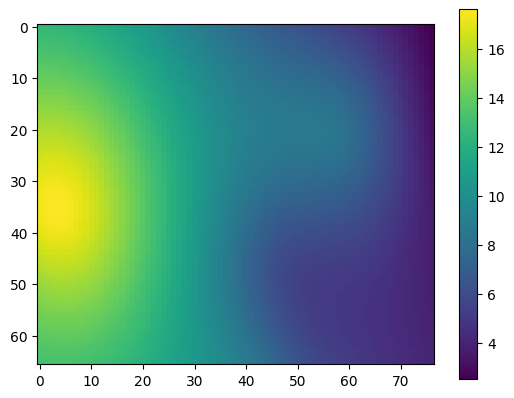

In [328]:
plt.imshow(y_pred_gp.reshape(lat_grid.shape))
plt.colorbar()

## Manual

In [299]:
def create_covariance_matrix(points, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may):
    n_points = len(points)
    cov_matrix = np.zeros((n_points, n_points))

    for i in prange(n_points):
        for j in prange(n_points):
            d = haversine(points[i][0], points[i][1], points[j][0], points[j][1])
            l = 0  # Ajusta según sea necesario
            h=1
            cov_matrix[i, j] = NSRP_cross_correlation(h, l, landa, mu_c, eta, xi, betha, alpha, alpha_p, fi_may, d)
    
    return cov_matrix

In [301]:
# Crear la matriz de covarianza para los puntos observados
K = create_covariance_matrix(points, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p],[fi_may])

In [302]:
# Puntos donde queremos hacer la predicción
pred_points = lon_lat_vector

def compute_k_star(i):
    K_star_row = np.zeros(len(points))
    for j in range(len(points)):
        d = haversine(pred_points[i][0], pred_points[i][1], points[j][0], points[j][1])
        l = 0  # Ajusta según sea necesario
        h=1
        K_star_row[j] = NSRP_cross_correlation(h, l, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p],[fi_may],d)
    return K_star_row

In [304]:
# Crear la matriz de covarianza cruzada entre puntos de predicción y puntos de observación
K_star = Parallel(n_jobs=-1)(delayed(compute_k_star)(i) for i in range(len(pred_points)))
K_star = np.array(K_star)

# Crear la matriz de covarianza para los puntos de predicción
K_star_star = create_covariance_matrix(pred_points, [landa], [mu_c], [eta], [xi], [betha], [alpha], [alpha_p],[fi_may])

# Invertir la matriz K
K_inv = np.linalg.inv(K)

# Realizar la predicción
y_pred = K_star @ K_inv @ values

# Calcular la incertidumbre de las predicciones
sigma_pred = np.sqrt(np.abs(np.diag(K_star_star - K_star @ K_inv @ K_star.T)))

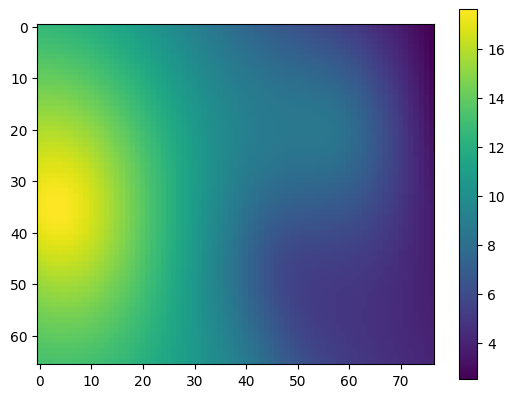

In [309]:
plt.imshow(y_pred.reshape(lat_grid.shape))
plt.colorbar()

# Kriging

In [366]:
# Crear los arrays de coordenadas
x_coords = points[:, 0]
y_coords = points[:, 1]

# Puntos donde queremos hacer la predicción
pred_points = lon_lat_vector  # pred_points contiene las coordenadas de los puntos de predicción
pred_x_coords = pred_points[:, 0]
pred_y_coords = pred_points[:, 1]

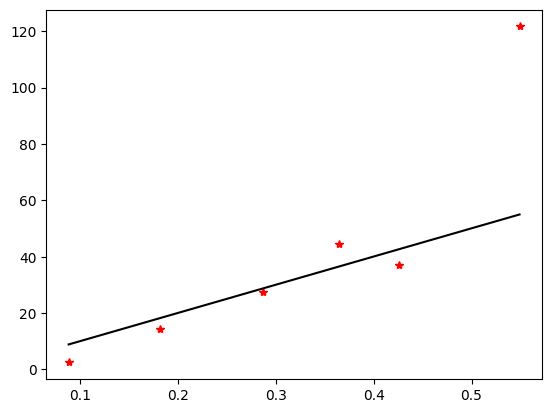

In [379]:
import numpy as np
from pykrige.ok import OrdinaryKriging
# Crear el objeto OrdinaryKriging
OK = OrdinaryKriging(
    x_coords, y_coords, values,
    variogram_model='linear',
    verbose=False, enable_plotting=True
)

# Realizar la predicción
z_pred, ss_pred = OK.execute('points', pred_x_coords, pred_y_coords)

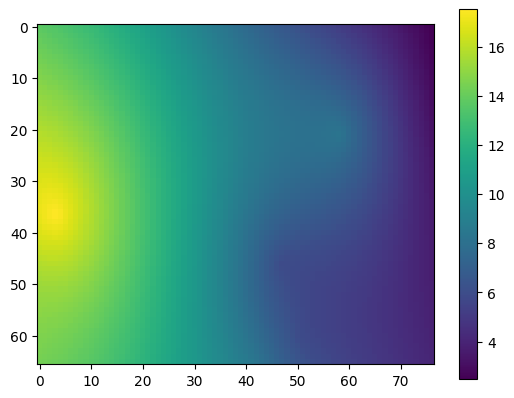

In [380]:
plt.imshow(z_pred.reshape(lat_grid.shape))
plt.colorbar()

In [381]:
z_pred

masked_array(data=[13.714579082089916, 13.629839685456007,
                   13.53989627750014, ..., 4.237360593057279,
                   4.152744404279401, 4.0681111991173475],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)